In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.svm import SVC

In [2]:
from google.colab import files
files.upload()

Saving mock_kaggle.csv to mock_kaggle.csv


{'mock_kaggle.csv': b'data,venda,estoque,preco\n2014-01-01,0,4972,1.29\n2014-01-02,70,4902,1.29\n2014-01-03,59,4843,1.29\n2014-01-04,93,4750,1.29\n2014-01-05,96,4654,1.29\n2014-01-06,145,4509,1.29\n2014-01-07,179,4329,1.29\n2014-01-08,321,4104,1.29\n2014-01-09,125,4459,1.09\n2014-01-10,88,5043,1.09\n2014-01-11,188,5239,1.09\n2014-01-12,121,5118,1.09\n2014-01-13,134,4984,1.09\n2014-01-14,80,4904,1.09\n2014-01-15,82,4822,1.09\n2014-01-16,94,4728,1.19\n2014-01-18,159,4464,1.19\n2014-01-19,199,4265,1.19\n2014-01-20,104,4161,1.19\n2014-01-21,70,4091,1.19\n2014-01-22,127,3964,1.09\n2014-01-23,96,3868,1.09\n2014-01-24,75,3793,1.09\n2014-01-25,198,3595,1.09\n2014-01-26,168,3427,1.09\n2014-01-27,125,3302,1.09\n2014-01-28,86,3216,1.09\n2014-01-29,222,2994,0.99\n2014-01-30,272,2723,0.99\n2014-01-31,209,2514,0.99\n2014-02-01,369,2145,0.99\n2014-02-02,217,1928,0.99\n2014-02-03,97,1831,0.99\n2014-02-04,117,1714,0.99\n2014-02-05,100,1998,1.29\n2014-02-06,64,2126,1.29\n2014-02-07,35,2091,1.29\n2014-02

In [5]:
sales=pd.read_csv("mock_kaggle.csv",parse_dates=True)
sales.head

<bound method NDFrame.head of            data  venda  estoque  preco
0    2014-01-01      0     4972   1.29
1    2014-01-02     70     4902   1.29
2    2014-01-03     59     4843   1.29
3    2014-01-04     93     4750   1.29
4    2014-01-05     96     4654   1.29
..          ...    ...      ...    ...
932  2016-07-27     98     3179   2.39
933  2016-07-28    108     3071   2.39
934  2016-07-29    128     4095   2.39
935  2016-07-30    270     3825   2.39
936  2016-07-31    183     3642   2.39

[937 rows x 4 columns]>

In [7]:
sales = sales.rename(columns={'data' : 'Date', 'venda' : 'Sales', 'estoque' : 'Stock', 'preco' : 'Price'})
sales.head()

,Date,Sales,Stock,Price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [8]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    937 non-null    object 
 1   Sales   937 non-null    int64  
 2   Stock   937 non-null    int64  
 3   Price   937 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 29.4+ KB


In [10]:
sales['Date'] = pd.to_datetime(sales['Date'], format='%Y-%m-%d')
sales = sales.assign(Day = sales.Date.dt.day,
               Month = sales.Date.dt.month,
               Year = sales.Date.dt.year)
sales['Revenue'] = sales['Sales'] * sales['Price']
sales.dtypes

Date       datetime64[ns]
Sales               int64
Stock               int64
Price             float64
Day                 int64
Month               int64
Year                int64
Revenue           float64
dtype: object

Text(0.5, 1.0, 'Revenue')

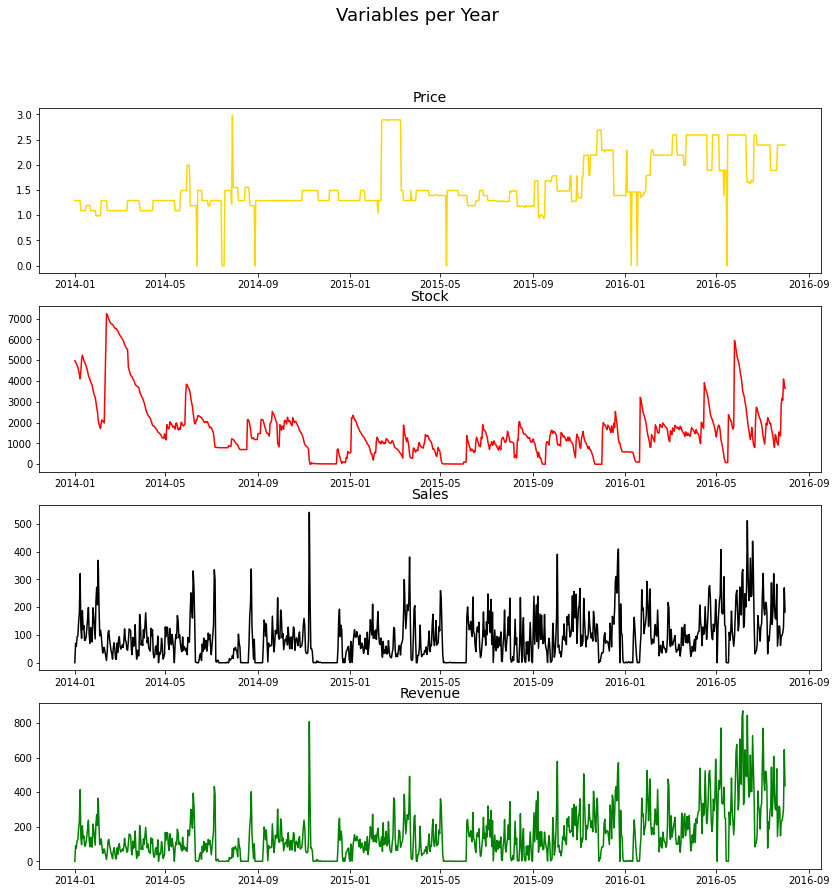

In [11]:
fig, axs = plt.subplots(4, figsize = [14, 14])
fig.suptitle('Variables per Year', fontsize = 18)
axs[0].plot(sales.Date, sales.Price, color = 'gold')
axs[0].set_title('Price', fontsize = 14)
axs[1].plot(sales.Date, sales.Stock, color = 'red')
axs[1].set_title('Stock', fontsize = 14)
axs[2].plot(sales.Date, sales.Sales, color = 'black')
axs[2].set_title('Sales', fontsize = 14)
axs[3].plot(sales.Date, sales.Revenue, color = 'green')
axs[3].set_title('Revenue', fontsize = 14)

In [14]:
corrMatrix = sales.corr()
print (corrMatrix)

            Sales     Stock     Price       Day     Month      Year   Revenue
Sales    1.000000  0.153659  0.094779 -0.062452 -0.020992  0.264477  0.912127
Stock    0.153659  1.000000 -0.032604  0.022778 -0.364307 -0.153145  0.151113
Price    0.094779 -0.032604  1.000000  0.001580 -0.062187  0.618943  0.399306
Day     -0.062452  0.022778  0.001580  1.000000  0.007236 -0.001551 -0.059509
Month   -0.020992 -0.364307 -0.062187  0.007236  1.000000 -0.265074 -0.021615
Year     0.264477 -0.153145  0.618943 -0.001551 -0.265074  1.000000  0.474632
Revenue  0.912127  0.151113  0.399306 -0.059509 -0.021615  0.474632  1.000000


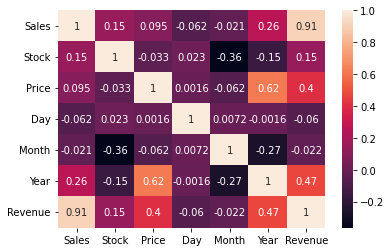

In [15]:
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [18]:
sales=sales.drop(['Revenue','Date','Year','Month','Day',],axis=1)
sales.head()


,Sales,Stock,Price
0,0,4972,1.29
1,70,4902,1.29
2,59,4843,1.29
3,93,4750,1.29
4,96,4654,1.29


In [34]:
values = sales.values
scaler = MinMaxScaler()
values = scaler.fit_transform(values)

y_scaler = MinMaxScaler()
y_scaler.fit(sales["Sales"].values.reshape(-1,1))

sales = pd.DataFrame(values, columns=["Sales", "Stock", "Price"])

In [35]:
sales.head()

,Sales,Stock,Price
0,0.000000,0.687880,0.432886
1,0.129151,0.678196,0.432886
2,0.108856,0.670033,0.432886
3,0.171587,0.657167,0.432886
4,0.177122,0.643885,0.432886


In [26]:
test_size = 30  # last month
train = sales.iloc[:-test_size, :]
y_train = train["Sales"].to_numpy()
x_train = train.to_numpy()

test  = sales.iloc[-test_size:]
y_test = test["Sales"].to_numpy()
x_test = test.to_numpy()

In [27]:
length = 1
train_generator = TimeseriesGenerator(x_train, y_train, length=length, batch_size=1)
test_generator = TimeseriesGenerator(x_test, y_test, length=length, batch_size=1)

In [28]:
number_of_features = 3  # (price, stock, sales)
number_of_targets = 1   # (sales)

model = Sequential()
model.add(LSTM(64, activation="relu", input_shape=(length, number_of_features)))
model.add(Dense(number_of_targets))

model.compile(
    optimizer="adam",
    loss="mse"  # Because this is a regression problem
)

# To prevent the model from over fitting over the data 
early_stopping = EarlyStopping(monitor="val_loss")

In [29]:
model.fit(
    train_generator,
    epochs=20,
    callbacks=[early_stopping],
    validation_data=test_generator,
    shuffle=False
)

Epoch 1/20
906/906 [==============================] - 7s 6ms/step - loss: 0.0157 - val_loss: 0.0176
Epoch 2/20
906/906 [==============================] - 5s 5ms/step - loss: 0.0123 - val_loss: 0.0178


In [30]:
predictions = model.predict(test_generator)

In [31]:
y_test = y_scaler.inverse_transform(y_test.reshape(-1,1))
predictions = y_scaler.inverse_transform(predictions.reshape(-1,1))

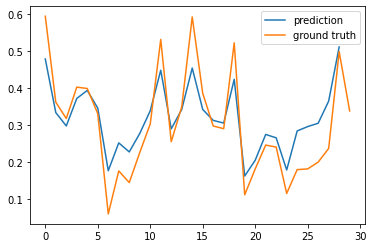

In [32]:
plt.plot(predictions, label="prediction")
plt.plot(y_test, label="ground truth")
plt.legend()
plt.show()

In [36]:
sales=pd.read_csv("mock_kaggle.csv",parse_dates=True)
sales.head

<bound method NDFrame.head of            data  venda  estoque  preco
0    2014-01-01      0     4972   1.29
1    2014-01-02     70     4902   1.29
2    2014-01-03     59     4843   1.29
3    2014-01-04     93     4750   1.29
4    2014-01-05     96     4654   1.29
..          ...    ...      ...    ...
932  2016-07-27     98     3179   2.39
933  2016-07-28    108     3071   2.39
934  2016-07-29    128     4095   2.39
935  2016-07-30    270     3825   2.39
936  2016-07-31    183     3642   2.39

[937 rows x 4 columns]>

In [38]:
sales = sales.rename(columns={'data' : 'Date', 'venda' : 'Sales', 'estoque' : 'Stock', 'preco' : 'Price'})
sales.head()

,Date,Sales,Stock,Price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [39]:
sales=sales.drop(['Date'],axis=1)
sales.head()

,Sales,Stock,Price
0,0,4972,1.29
1,70,4902,1.29
2,59,4843,1.29
3,93,4750,1.29
4,96,4654,1.29


In [40]:
test_size = 30  # last month
train = sales.iloc[:-test_size, :]
y_train = train["Sales"].to_numpy()
x_train = train.to_numpy()

test  = sales.iloc[-test_size:]
y_test = test["Sales"].to_numpy()
x_test = test.to_numpy()

In [41]:
from sklearn.tree import DecisionTreeClassifier
classifier=DecisionTreeClassifier(criterion='gini')
classifier.fit(x_train,y_train)


DecisionTreeClassifier()

In [42]:
classifier.score(x_test,y_test)

0.6333333333333333

In [43]:
classifier=DecisionTreeClassifier(criterion='entropy')
classifier.fit(x_train,y_train)


DecisionTreeClassifier(criterion='entropy')

In [44]:
classifier.score(x_test,y_test)

0.7